## DML-Project
Object detection and classification of strawberry ripeness

### Imports

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor

### Image folders

In [60]:
train_data = "./data/train"
val_data   = "./data/val"
test_data  = "./data/test"

### Load datasets and apply transformations

Mosaic augmentation,
flips and rotations,
resize,
zoom in,
crop

In [ ]:
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image

class StrawberryData(Dataset):
    
    def __init__(self, root, transform, ripe_label=0, unripe_label=1, anomalous_label=2):
        """Constructor
        
        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """
        
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")
            
        self.root = root
        self.transform = transform
        self._ripe_label = ripe_label
        self._unripe_label = unripe_label
        self._anomalous_label = anomalous_label

        
        # Collect samples, both cat and dog and store pairs of (filepath, label) in a simple list.
        self._samples = self._collect_samples()
            
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path, label = self._samples[index]
        # Load the image into memory
        img = Image.open(path)
        # Perform transforms, if any.
        if self.transform is not None:
            img = self.transform(img)
        return img, label
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """
        # Iterator over dog filpath
        ripe_paths = self._collect_imgs_sub_dir(self.root / "ripe")
        # Iterator of pairs (path, dog label)
        # Again, we use the `map` function to create an iterator. It's use is not as common as the so called
        # 'list comprehension' you've previously seen, but a good alternative to have seen.
        dog_paths_and_labels = map(lambda path: (path, self._dog_label), dog_paths)
        # Same for cats
        cat_paths = self._collect_imgs_sub_dir(self.root / "cats")
        cat_paths_and_labels = map(lambda path: (path, self._cat_label), cat_paths)
        # Sorting is not strictly necessary, but filesystem globbing (wildcard search) is not deterministic,
        # and consistency is nice when debugging.
        return sorted(list(chain(dog_paths_and_labels, cat_paths_and_labels)), key=lambda x: x[0].stem)
     
    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.jpg")
    
    def get_sample_by_id(self, id_):
        """Get sample by image id
        
        Convenience method for exploration.
        The indices does not correspond to the image id's in the filenames.
        Here is a (rather inefficient) way of inspecting a specific image.
        
        Args:
            id_ (str): Image id, e.g. `dog.321`
        """
        id_index = [path.stem for (path, _) in self._samples].index(id_)
        return self[id_index]


In [77]:
transform = Compose([ToTensor()])
train_dataset = ImageFolder(train_data, transform)
val_dataset   = ImageFolder(val_data, transform)
test_dataset  = ImageFolder(test_data, transform)

### Example image from the dataset

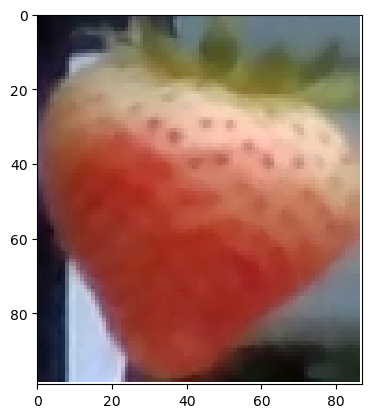

In [78]:
def display_image(axis, image_tensor):
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError("The `display_image` function expects a `torch.Tensor` " +
                        "use the `ToTensor` transformation to convert the images to tensors.")
        
    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    axis.set_ylim(height, 0)

_, axis = plt.subplots()
image_tensor, label = dataset[150]
display_image(axis, image_tensor)

### Dataloaders